In [1]:
%matplotlib inline
%load_ext tensorboard

In [94]:
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image

import tensorflow as tf
import IPython.display as display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import os, pathlib, math

In [3]:
autotune = tf.data.experimental.AUTOTUNE

In [13]:
# download or fetch file from cache directory
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_directory = tf.keras.utils.get_file(
   origin = url,
   fname = os.path.basename(os.path.normpath(url)).split(".")[0],
   untar = True
)

data_dir = pathlib.Path(data_directory)

In [93]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


In [16]:
# check directory contents
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [18]:
# get class information based on the directories and ignore other file
class_names = np.array([
   item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"
])

print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


### Random Sampling

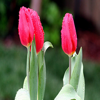

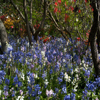

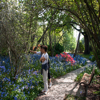

<Figure size 720x432 with 0 Axes>

In [34]:
tulips = list(
   data_dir.glob("tulips/*")
)

plt.figure(figsize = (10, 6))
for image_path in tulips[:3]:
   display.display(Image.open(str(image_path)).resize((100, 100)))

In [59]:
list_ds = tf.data.Dataset.list_files(
   str(data_dir/"*/*")
)

print("Variable {} now is type of {}\n".format("list_ds", type(list_ds)))
print("Data specifications:")
print(list_ds.element_spec , "\n")

# test the result
for f in list_ds.take(5):
   print(f.numpy())

Variable list_ds now is type of <class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>

Data specifications:
TensorSpec(shape=(), dtype=tf.string, name=None) 

b'C:\\Users\\Ridzuan\\.keras\\datasets\\flower_photos\\sunflowers\\8480886751_71d88bfdc0_n.jpg'
b'C:\\Users\\Ridzuan\\.keras\\datasets\\flower_photos\\tulips\\5470898169_52a5ab876c_n.jpg'
b'C:\\Users\\Ridzuan\\.keras\\datasets\\flower_photos\\roses\\15566697073_9a214b700e_n.jpg'
b'C:\\Users\\Ridzuan\\.keras\\datasets\\flower_photos\\tulips\\14067778605_0285b7cc3a.jpg'
b'C:\\Users\\Ridzuan\\.keras\\datasets\\flower_photos\\tulips\\17159816388_deafbebdb0.jpg'


In [60]:
batch_size = 32
img_dim = 224

def get_label(file_path):
   parts = tf.strings.split(file_path, os.path.sep)
   return parts[-2] == class_names

def decode_image(img):
   img = tf.image.decode_jpeg(img, channels = 3)
   img = tf.image.convert_image_dtype(img, tf.float32)
   return tf.image.resize(img, [img_dim, img_dim])

def process_path(file_path):
   label = get_label(file_path)
   img = tf.io.read_file(file_path)
   img = decode_image(img)
   return img, label

In [61]:
labeled_ds = list_ds.map(
   process_path,
   num_parallel_calls = autotune
)

print("Variable {} now is type of {}\n".format("labeled_ds", type(list_ds)))
print("Data specifications:")
print(labeled_ds.element_spec , "\n")

Variable labeled_ds now is type of <class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>

Data specifications:
(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.bool, name=None)) 



In [62]:
for image, label in labeled_ds.take(1):
   print("Image shape: ", image.numpy().shape)
   print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


In [67]:
def prepare_for_training(dataset, cache = True, shuffle_buffer_size = 1000):
   
   if cache:
      if isinstance(cache, str):
         dataset = dataset.cache(cache)
      else:
         dataset = dataset.cache()
   
   # steps:
   # shuffle all data to cache everything
   # -> repeat forever
   # ->-> combine into batches
   # ->->-> prefetch
   dataset = dataset.shuffle(buffer_size = shuffle_buffer_size).repeat().batch(batch_size).prefetch(buffer_size = autotune)
      
   return dataset

In [95]:
prepared_data = prepare_for_training(labeled_ds)
train_ds = prepared_data.take(math.floor(0.8 * image_count))
test_ds = prepared_data.skip(math.floor(0.8 * image_count))

print("Variable {} now is type of {}\n".format("train_ds", type(train_ds)))
print("Data specifications:")
print(train_ds.element_spec , "\n")

Variable train_ds now is type of <class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>

Data specifications:
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)) 



In [76]:
# function to random sampling batch
def show_batch(image_batch, label_batch):
   plt.figure(figsize = (10, 10))
   for n in range(25):
      plt.subplot(5, 5, n + 1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n] == 1][0].title())
      plt.axis("off")

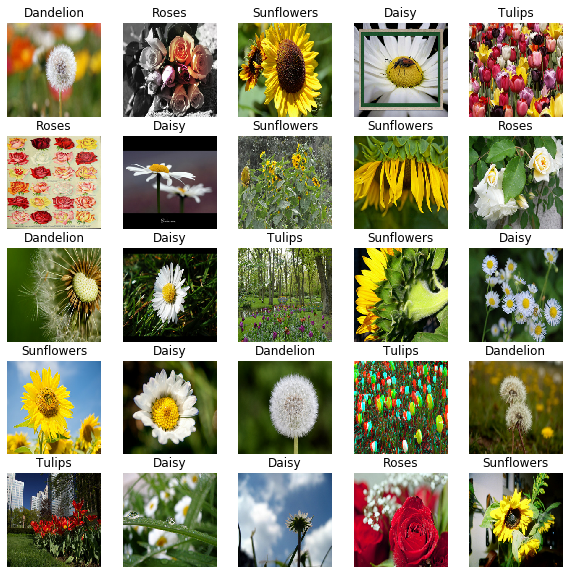

In [77]:
# test sample from prepared data
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [80]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_dim, img_dim, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
history = model.fit_generator(
   train_ds,
   epochs=10,
   steps_per_epoch = 100,
   validation_data = test_ds,
   validation_steps = 100
)

Train for 100 steps, validate for 100 steps
Epoch 1/10
100/100 [==============================] - 177s 2s/step - loss: 0.0154 - accuracy: 0.9961 - val_loss: 0.0274 - val_accuracy: 0.9905
Epoch 2/10
100/100 [==============================] - 132s 1s/step - loss: 0.0277 - accuracy: 0.9911 - val_loss: 0.0084 - val_accuracy: 0.9972
Epoch 3/10
100/100 [==============================] - 133s 1s/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0185 - val_accuracy: 0.9948
Epoch 4/10
100/100 [==============================] - 134s 1s/step - loss: 0.0300 - accuracy: 0.9916 - val_loss: 0.0202 - val_accuracy: 0.9944
Epoch 5/10
100/100 [==============================] - 133s 1s/step - loss: 0.0286 - accuracy: 0.9931 - val_loss: 0.0147 - val_accuracy: 0.9960
Epoch 6/10
100/100 [==============================] - 133s 1s/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 7/10
100/100 [==============================] - 132s 1s/step - loss: 0.0087 - accuracy: 0.99

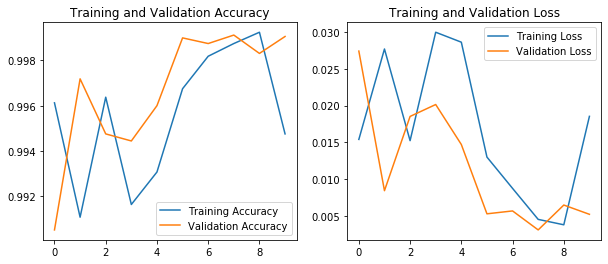

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [91]:
history